In [15]:
!pip install tensorflow numpy bing-image-downloader pillow matplotlib

  Using cached matplotlib-3.5.1-cp39-cp39-manylinux_2_5_x86_64.manylinux1_x86_64.whl (11.2 MB)
  Using cached kiwisolver-1.4.2-cp39-cp39-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.6 MB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
     |████████████████████████████████| 930 kB 1.5 MB/s eta 0:00:01


In [16]:
import tensorflow as tf
import numpy as np
import glob
from bing_image_downloader import downloader
from PIL import Image
from matplotlib import pyplot as plt

In [80]:
CLASSES = [
	'macbook',
	'toilet',
	'hotdog',
	# 'equation',
	'keyboard',
	'phone',
	'pancake'
]
IMGS_PER_CLASS = 100
IMG_SHAPE = (224, 224)
TEST_SIZE = int((len(CLASSES) * IMGS_PER_CLASS)*.2)
BATCH_SIZE = 8

In [51]:
# Download data
for class_name in CLASSES:
	downloader.download(
		class_name,
		limit=IMGS_PER_CLASS,
		output_dir='dataset',
		adult_filter_off=False,
		force_replace=False,
		timeout=60,
		verbose=False
	)

[%] Downloading Images to /home/jankaifer/Projects/colabs/priroda/dataset/macbook
[!] Issue getting: https://appleinclusion.com/wp-content/uploads/2019/05/howard-lawrence-b-1141813-unsplash-1.jpg
[!] Error:: HTTP Error 404: Not Found
[!] Issue getting: https://external-preview.redd.it/5BCTe6GcIWnfl0RT6W9jsNIOeRoQ4K36oc24vpmzAeY.jpg?auto=webp&amp;s=2c9d35b3a5b39c78d0699d35c48e34a6214d2cb3
[!] Error:: HTTP Error 403: Forbidden
[!] Issue getting: https://preview.redd.it/b0oy5ewj05e51.jpg?auto=webp&amp;s=be3cf283476f60f65b4b1d058c0441ddc2c93a21
[!] Error:: HTTP Error 403: Forbidden
[!] Issue getting: https://preview.redd.it/1haehzc1gq351.jpg?auto=webp&amp;s=cd4c500e5f3014a18c704f478c121f54f72fe9a9
[!] Error:: HTTP Error 403: Forbidden
[!] Issue getting: https://static.swappa.com/media/listing/LRHB24663/BqgLICvU.jpg
[!] Error:: HTTP Error 503: Service Temporarily Unavailable
[Error]Invalid image, not saving https://miro.medium.com/max/1200/1*nQqSw3LQHwOoKE3fv5Vr6g.jpeg

[!] Issue getting: h

In [84]:
def create_class_ds(path, class_name):
    def generator():
        for filename in glob.glob(f'{path}/*.*'):
            im = Image.open(filename).convert('RGBA')
            background = Image.new('RGBA', im.size, (255,255,255))
            im = Image.alpha_composite(background, im).convert('RGB')
            im = im.resize(IMG_SHAPE)
            yield np.array(im) / 255., CLASSES.index(class_name)
    
    return tf.data.Dataset.from_generator(
        generator,
        output_signature=(tf.TensorSpec(shape=(*IMG_SHAPE, 3), dtype=tf.float32), tf.TensorSpec(shape=(), dtype=tf.uint8)),
    )

class_datasets = [create_class_ds('dataset/' + class_name, class_name) for class_name in CLASSES]

ds = tf.data.Dataset.sample_from_datasets(class_datasets, seed=42)

test_ds = ds.take(TEST_SIZE).cache()
train_ds = ds.skip(TEST_SIZE).cache()

In [85]:

def preview_ds(ds, rows=1, cols=15, figure_width=20):
  first_image = np.array(list(ds.take(1))[0][0])
  ratio = first_image.shape[0] / first_image.shape[1]
  line_height = figure_width / cols * ratio + .2
  figure_height = line_height * rows
  fig = plt.figure(figsize=(figure_width, figure_height))
  n = cols * rows
  
  # ax enables access to manipulate each of subplots
  ax = []

  for i, data in enumerate(ds.take(n)):
    img, label = [x.numpy() for x in data]
    # create subplot and append to ax
    ax.append(fig.add_subplot(rows, cols, i+1))
    ax[-1].set_title(CLASSES[label])
    plt.axis('off')
    plt.imshow(img)
  
  plt.show()
  

2022-04-25 21:19:00.478528: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-04-25 21:19:11.744000: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


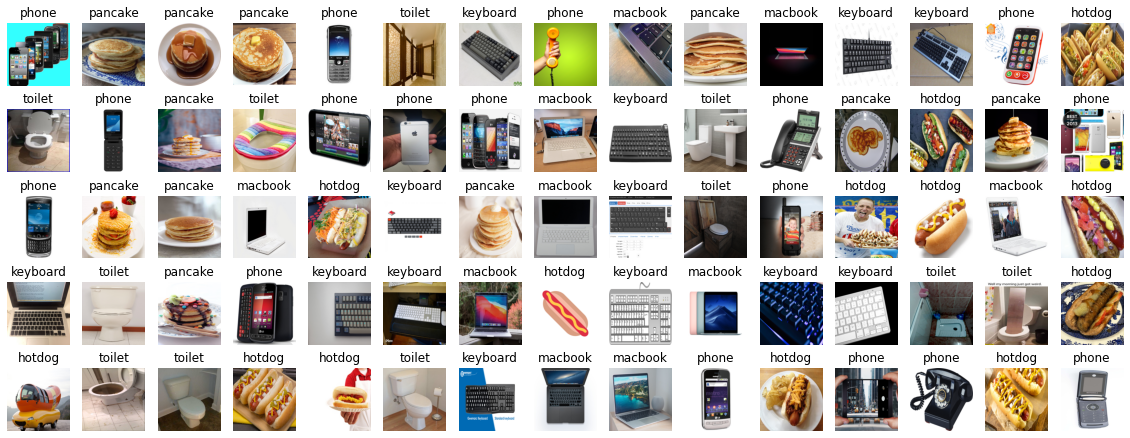

In [86]:
preview_ds(train_ds, rows=5)

In [106]:
def train_and_benchmark_model(model, epochs=1):
	model.summary()
	model.compile(
		optimizer='adam',
		loss='sparse_categorical_crossentropy',
		metrics=['accuracy']
	)
	model.fit(
		train_ds.batch(BATCH_SIZE),
		epochs=epochs,
		validation_data=test_ds.batch(BATCH_SIZE),
	)

In [116]:
def non_trainable(model):
	model.trainable = False
	return model

def with_backbone(model):
	return tf.keras.Sequential([
		tf.keras.layers.Input(shape=(*IMG_SHAPE, 3)),
		model,
		tf.keras.layers.Flatten(),
		tf.keras.layers.Dense(len(CLASSES), activation='softmax')
	])

In [112]:
train_and_benchmark_model(model=with_backbone(
	tf.keras.Sequential([
		tf.keras.layers.Conv2D(32, 3, activation='relu'),
		tf.keras.layers.MaxPooling2D(),
		tf.keras.layers.Conv2D(64, 3, activation='relu'),
		tf.keras.layers.GlobalMaxPool2D(),
	])
))

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_36 (Sequential)  (None, 64)                19392     
                                                                 
 flatten_32 (Flatten)        (None, 64)                0         
                                                                 
 dense_39 (Dense)            (None, 6)                 390       
                                                                 
Total params: 19,782
Trainable params: 19,782
Non-trainable params: 0
_________________________________________________________________
62/62 [==============================] - 7s 107ms/step - loss: 1.7170 - accuracy: 0.2901 - val_loss: 1.6187 - val_accuracy: 0.4167


In [117]:
train_and_benchmark_model(
	with_backbone(
		tf.keras.Sequential([
			non_trainable(
				tf.keras.applications.efficientnet.EfficientNetB0(include_top=False, pooling='avg'),
			),
			tf.keras.layers.Dense(10, activation='relu'),
		]),
	),
	epochs=5
)

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_40 (Sequential)  (None, 10)                4062381   
                                                                 
 flatten_35 (Flatten)        (None, 10)                0         
                                                                 
 dense_43 (Dense)            (None, 6)                 66        
                                                                 
Total params: 4,062,447
Trainable params: 12,876
Non-trainable params: 4,049,571
_________________________________________________________________
Epoch 1/5
62/62 [==============================] - 11s 120ms/step - loss: 1.8019 - accuracy: 0.1704 - val_loss: 1.7942 - val_accuracy: 0.1250
Epoch 2/5
62/62 [==============================] - 7s 107ms/step - loss: 1.7934 - accuracy: 0.1643 - val_loss: 1.7934 - val_accuracy: 0.1250
Epoch 3/5
62/62 [==

In [78]:
train_and_benchmark_model(
	with_backbone(
		non_trainable(
			tf.keras.applications.vgg16.VGG16(include_top=False, pooling='max'),
		),
	),
)

82/82 [==============================] - 174s 2s/step - loss: 2.2103 - accuracy: 0.1424 - val_loss: 3.1923 - val_accuracy: 0.1063


In [119]:
train_and_benchmark_model(
	with_backbone(
		non_trainable(
			tf.keras.applications.mobilenet_v2.MobileNetV2(include_top=False, pooling='max', input_shape=(*IMG_SHAPE, 3)),
		),
	),
)

Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 flatten_37 (Flatten)        (None, 1280)              0         
                                                                 
 dense_45 (Dense)            (None, 6)                 7686      
                                                                 
Total params: 2,265,670
Trainable params: 7,686
Non-trainable params: 2,257,984
_________________________________________________________________
62/62 [==============================] - 5s 62ms/step - loss: 1.3522 - accuracy: 0.6856 - val_loss: 0.2286 - val_accuracy: 0.9333


# Závěr
Na to že všechny modely (efficient-net, VGG i mobile-net) jsou trénované na imagenetu, tak dávají překvapivě jiné výsledky. Konkrétně fungoval pouze mobile net.

Byl jsem překvapený tím, jak špatný je efficient-net. Ani když jsem mu dal trochu více vrstev, tak se nedokázal naučit nic rozumného. Když jsem měl v seznamu i labels `equation` a `code`, tak se byl schopný overfitnout na 60% (test byl pořád kolem 12%).

Je to tím, že moje data jsou velmi specifická a různorodá (třeba label `phone`). Pokud bych měl více obrázků z reálného světa, které jsou více podobné image netu, tak by dost možná `vgg` i `efficient-net` dopadli mnohem lépe.